# Bayesian Optimization of a Technical Trading Algorithm with SigOpt

Authors: Justin Lent (Quantopian), Thomas Wiecki (Quantopian), [Scott Clark](https://sigopt.com/about#scott) ([SigOpt](https://sigopt.com))

Parameter optimization of trading algorithms is quite different from most other optimization problems. Specifically, the optimization problem is non-convex, non-linear, stochastic, and can include a mix of integers, floats and enums as parameters. Moreover, most optimizers assume that the objective function is quick to evaluate which is definitely not the case for a trading algorithm run over multiple years of financial data. Immediately that disqualifies 95% of optimizers including those offered by `scipy` or `cvxopt`. At Quantopian we have long been interested in parameter optimization of trading algorithms (some prior blog posts on this topic can be found [here](), [here](), and [here]()). 

**Bayesian optimization** is a rather novel approach to the selection of parameters that is very well suited to optimize trading algorithms. This blog post will first provide a short introduction to Bayesian optimization with a focus on why it is well suited for quantitative finance. We will then show how you can use [SigOpt](http://sigopt.com/) to perform Bayesian optimization on your own trading algorithms running with [`zipline`](https://github.com/quantopian/zipline).

This blog post originally resulted from a collaboration with Alex Wiltschko where we used Whetlab for Bayesian optimization. Whetlab, however, has since been acquired by Twitter and the Whetlab service was discontinued. Scott Clark from SigOpt helped in porting the code to their service which is comparable in functionality and API. Scott also co-wrote the blog post.

## Introduction to Bayesian optimization (Scott)

[Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) is a powerful tool that is particularly useful when optimizing anything that is both time consuming and expensive to evaluate (like trading algorithms). At the core, Bayesian Optimization attempts to leverage historical observations to make optimal suggestions on the best variation of parameters to sample (maximizing some objective like expected returns). This field has been actively studied in academia for decades, from the seminal paper ["Efficient Global Optimization of Expensive Black-Box Functions"](http://www.ressources-actuarielles.net/EXT/ISFA/1226.nsf/0/f84f7ac703bf5862c12576d8002f5259/$FILE/Jones98.pdf) by Jones et al. in 1998 to more recent contributions like ["Practical Bayesian Optimization of Machine Learning Algorithms"](http://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf) by Snoek et al. in 2012.

Many of these approaches take a similar route to solving the problem: they map the observed evaluations onto a [Gaussian Process](http://blog.sigopt.com/post/130275376068/sigopt-fundamentals-intuition-behind-gaussian) (GP), [fit the best possible GP model](http://blog.sigopt.com/post/131498069303/sigopt-fundamentals-intuition-behind-covariance), perform optimization on this model, then return a new set of suggestions for the user to evaluate. At the core, these methods balance the tradeoff between exploration (learning more about the model, the length scales over which they vary, and how they combine to influence the overall objective) and exploitation (using the knowledge already gained to return the best possible expected result). By efficiently and automatically making these tradeoffs, Bayesian Optimization techniques can quickly find the global optima of these difficult to optimize problems, often much faster than traditional methods like brute force or localized search.

At every Bayesian Optimization iteration, the point of highest Expected Improvement is returned; this is the set of parameters that, in expectation, will most improve upon the best objective value observed thus far. SigOpt wraps these powerful optimization techniques behind a simple API so that any expert in any field can optimize their models without resorting to expensive trial and error. More information about how SigOpt works, as well as other examples of using Bayesian Optimization to perform parameter optimization, can be found on our [research page](https://sigopt.com/research).

## A Generalized Framework for Evaluating Trading Signals (Justin)

Historically quant traders have used many price based signals to define an investment strategy. Many of these signals have been implemented into the popular [TA-lib library](http://ta-lib.org/), with an available Python library [here](https://github.com/mrjbq7/ta-lib).  Typically, a price based signal takes in historical prices as input to compute the signal's value.  For example, RSI [(Relative Strength Index)](http://www.investopedia.com/terms/r/rsi.asp), is commonly used for mean-reversion and momentum trading.  To compute RSI one must first choose the number of pricing days over which to compute the signal. Then, the trader chooses a range of values for determining when to enter a trade. The valid values for RSI is between 0 to 100. If a stock has undergone a sharp selloff recently, RSI values will trend towards 0, and after a strong rally, trend towards 100.  A common trading strategy is going long a stock when RSI is below 20, betting on mean-reversion.  Similarly, to go short when RSI is above 80.  However, other groups of traders have found success betting on persistent momentum in the stock (rather than mean-reversion) when RSI reaches an extreme reading. In which case, the trader will go long when RSI is above 80 betting that the stock will continue going higher.  

This poses several questions:
* So which is right? Should we use RSI as a _mean-reversion_ indicator or a _momentum_ indicator?  
  * What range of RSI values shall we choose to determine if the momentum or mean-reversion condition is met?
  * How many lookback days of prices should we use to compute the stock's RSI?
* Besides RSI, can I integrate a second indicator into my investment strategy?

Each decision made regarding specifying our trading signal (e.g. RSI) or how to interpret the signal's value for making a trading decision is effectively a free parameter in our system, and depending upon the range of reasonable values each free parameter can take, it can quickly explode the total combinations of possible settings. Each signal added to the strategy can quickly increase the total combinations possible into the many millions and even _billions_, even with just 2 signals, as we'll see in the below example. A discussion of strategy model overfitting, and evaluating how overfit a trading backtest may be, will not be addressed here, but will be the topic of a future blog post.  An excellent introduction for addressing trading strategy overfitting can be found here:  .

The large parameter space of millions, or billions, of combinations over which our strategy will need to be tested in order to determine the subspace where the global maximum is likely located is why Bayesian Optimization can be so effective at quickly evaluating potentially profitable trading strategies.  Brute force grid-search over a billion combination parameter space is often intractable, even if each combination only takes 30-seconds to complete.  Bayesian optimization decreases the evaluation of the model over the global search space by an order of magnitude, as described in the previous section.

The trading algorithm we will implement below will create a simple structure for passing in the free parameters of any number simple price based trading signals (simplified to work more easily with ta-lib functions). Then each signal is evaluated each trading day, when _all_ the conditions are true, a trade is entered, and held until the next signal evaluation period. 

For the purposes of this optimization our objective function will be [Sharpe Ratio](http://www.investopedia.com/terms/s/sharperatio.asp) of the strategy. A broadly accepted metric from industry for evaluating trading strategy performance.  However, the framework implemented below allows for ease of swapping in any objective function desired by the analyst.


## Example Zipline algorithm

To illustrate how you can use Bayesian optimization on your [zipline](https://github.com/quantopian/zipline) trading algorithms and how it compares to other naive approaches (i.e. grid search) we will use a rather simple algorithm comprised of a trading trigger based on two commonly used signals from the ta-lib library, RSI [(Relative Strength Index)](http://www.investopedia.com/terms/r/rsi.asp) and ROC [(Rate of Change)](http://www.investopedia.com/terms/p/pricerateofchange.asp). 

The trading algorithm will search for trades across these Select Sector SPDR ETF's: 
* XLV, XLF, XLP, XLE, XLK, XLB, XLU, XLI. 

By running the trading logic across all of these ETF's we will be implementing a simple sector-rotation strategy. 

#####-----------------------------------------------------------------------------------------------------
#####Strategy Specification
*Buy the ETF only if it meets _both_ the RSI signal and ROC signal criteria.  When an ETF is bought long, then an equivalent dollar amount of SPY will be shorted, creating a hedged, dollar-neutral portfolio.*
#####-----------------------------------------------------------------------------------------------------

By hedging all of our trades, it serves to "tease-apart" the actual usefulness provided by these signals (RSI, ROC) since it extracts upward movement in the stock simply occurring because the rest of the stock market is going up.  As a result, the profit achieved by this hedged strategy can be perceived as more "pure alpha," rather than highly-correlated to the direction of the broad stock market.

The 7 free parameters of our trading strategy are as follows:
* RSI
  * **(1)** Lookback window for # of prices used in the RSI calculation
  * **(2)** Lower_bound value defining the trade entry condition
  * **(3)** Range_width, which will be added to the Lower-bound
    * Lower_bound + Range_width is the range of values over which our RSI signal will be considered `True`
* ROC
  * **(4)** Lookback window for # of prices used in the ROC calculation
  * **(5)** Lower_bound value defining the trade entry condition
  * **(6)** Range_width, which will be added to the Lower-bound
    * Lower_bound + Range_width is the range of values over which our ROC signal will be considered `True`
* Signal evaluation frequency
  * **(7)** Number of days we wait between evaluating if our signals are valid
    * Do we evaluate them every day, every week, every month, etc.

It's worth noting that even with just 2 price based signals, we have 7 free parameters in this system!

Reasonable Ranges for each of the 7 free parameters above (assuming each is an integer, with integer steps):
1. 115 values: 5 to 120 
2. 90 values: 0 to 90
3. 20 values: 10 to 30
4. 61 values: 2 to 63
5. 30 values: 0 to 30
6. 195 values: 5 to 200
7. 18 values: 3 to 21

Multiplying the valid ranges of each yields a total combination count of:
* **1,329,623,100,000** theoretical combinations 
  * 115 x 90 x 20 x 61 x 30 x 195 x 18 
(TODO: check with Thomas on this math)
  * Imagine how many combinations are possible if 3, 4, 5... 10 signals are added to a strategy

Obviously grid-searching through all those combinations is unreasonable, though a skilled practitioner can prune the search space significantly by only grid-searching across each parameter using wider steps based on their intuition of the model they are building.  But even if the skilled practitioner can reduce the grid-search to 10,000 combinations even that number of combinations may be unwieldy if the objective function (e.g. trading strategy) takes 1-minute to evaluate, which is quite frequently the case with trading strategies.  This is where the benefit of having access to a Bayesian optimizer becomes _extremely_ helpful.  

The ipython notebook below compares SigOpt's Bayesian Optimizer's results from 3 independent experiments, of only 300 trials each determined intelligently by their optimizer, to a "smart" grid-search of approximately 3500 combinations chosen intuitively from a reasonable interpretations of sensible RSI and ROC values.  Only 3500 trials were chosen for the grid-search approach, because even that few combinations took 48 hours to evaluate. 300 trials were chosen for the SigOpt approach because in practice the SigOpt optimizer is able to find good optima within 10 to 20 times the dimensionality of the parameter space being optimized. This linear number of evaluations with respect to the number of parameters allows for optimization of algorithms that would otherwise be intractable using standard methods like grid search, which grow exponentially with the number of parameters.
 

## Conclusion
### *The SigOpt Bayesian Optimizer discovered a better global maximum when testing only over only 300 combinations, than what was discovered by the ~3500 combination grid search.*  
####(This was seen in 4 out of 5 runs with SigOpt, and the 1 that returned a worse value was only minor shortfall)   

*One Example of how quickly SigOpt discovered a maximum is shown below*
![alt text](SigOpt_max_over_time.png)
![alt text](SigOpt_vs_GridSearch_sorted_value_comparison.png)
![alt text](SigOpt_vs_GridSearch_time_comparison.png)

**Reducing model evaluation by 10x, and achieving more accurate results, while vetting the merits of a trading algorithm is beneficial on many levels, both from CPU time spent, but also with regard to human time not being wasted waiting for results during the researh process.  Since so few trading hypotheses end up being viable, the faster a researcher can discard the bad ideas and spend time diving more deeply in the good ideas with further techniques (e.g. model cross-validation, out-of-sample testing, robustness and overfitting checks, etc).** 



## -----------------------------------------------------------------------------------------

## Implementing our Trading Algo & Running Optimizations
We start by importing our tools. Also note that if you want to run this yourself you need to create a file in this folder called `creds.py` where you place your SigOpt credentials (a free trial is avaible if you go to [SigOpt.com](https://sigopt.com)).

In [1]:
"""
    This cell is for importing all our necessary libraries
"""
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import talib
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from collections import defaultdict
import itertools

import zipline
from zipline.utils.factory import load_bars_from_yahoo

try:
    import pyfolio as pf
except ImportError:
    print('Pyfolio not installed. Pyfolio specific plots will not be available in this notebook.')
    
try:
    import creds
except ImportError:
    raise ValueError('creds.py not found. Please create it and set user_token, client_token and client_id from https://sigopt.com/user/profile')

Next we will load in pricing data via Yahoo! finance.

In [2]:
#: Get pricing for the same dates in daily mode
data = load_bars_from_yahoo(stocks=['XLV', 'XLF', 'XLP','XLE', 'XLK', 'XLB', 'XLU', 'XLI','SPY'
                                    ],
                            start=pd.Timestamp('2004-01-01', tz='utc'),
                            end=pd.Timestamp('2010-01-01', tz='utc')
                           )

data_heldout = load_bars_from_yahoo(stocks=[ 'XLV', 'XLF', 'XLP','XLE', 'XLK', 'XLB', 'XLU', 'XLI', 'SPY'
                                            ],
                                    start=pd.Timestamp('2010-01-10', tz='utc'),
                                    end=pd.Timestamp('2016-1-7', tz='utc')
                                   )

data_all = load_bars_from_yahoo(stocks=[ 'XLV', 'XLF', 'XLP','XLE', 'XLK', 'XLB', 'XLU', 'XLI', 'SPY'
                                        ],
                                start=pd.Timestamp('2004-01-01', tz='utc'),
                                end=pd.Timestamp('2016-1-7', tz='utc')
                               )

XLV
XLF
XLP
XLE
XLK
XLB
XLU
XLI
SPY
XLV
XLF
XLP
XLE
XLK
XLB
XLU
XLI
SPY
XLV
XLF
XLP
XLE
XLK
XLB
XLU
XLI
SPY


## Trading Algo:  Sector Rotation, using Sector SPDR ETF's, with Hedging

In [5]:
import matplotlib
import pytz
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import talib
import seaborn as sns

import matplotlib.pyplot as plt

# Zipline imports
from zipline.utils.factory import load_bars_from_yahoo
from zipline import TradingAlgorithm
from zipline.api import (
    order_target, 
    record, 
    symbol,
    get_datetime, 
    order_target_percent
)
from zipline.api import order_target_percent, record, symbol, symbols, history, add_history
from collections import OrderedDict


def initialize_local_sigopt_rsi_roc(context, signals_input=None, 
                            rsi_timeperiod=-1, rsi_lower=29, rsi_width=27,
                            roc_timeperiod=13, roc_lower=0.00, roc_width=2.00, 
                            rebalance_freq=21, 
                            max_pos_exp=0.3, min_stocks_for_full_exp=3, 
                            use_hedge=True, 
                            debug=False):
    
    context.debug = debug
    context.use_hedge = use_hedge
    context.rebalance_freq = rebalance_freq
    
    context.max_pos_exp = max_pos_exp
    context.min_stocks_for_full_exp = min_stocks_for_full_exp
    
    # A code simplification to make the downstream optimization analysis more straigtforward
    if rsi_timeperiod > 0:
        context.signals = OrderedDict([
                                        ( 'rsi', {'func': talib.RSI, 'func_kwargs': {'timeperiod': rsi_timeperiod}, 
                                                       'lower': rsi_lower,  'width': rsi_width} ),
                                        ( 'roc', {'func': talib.ROCP, 'func_kwargs': {'timeperiod': roc_timeperiod }, 
                                                       'lower': roc_lower, 'width': roc_width, } )
                                    ])
    else:
        if signals_input is None:
            context.signals = signals
        else:
            context.signals = signals_input
    
    print "rebal freq: " + str(context.rebalance_freq)
    print context.signals
    
    context.max_timeperiod = 0
    for signal_name in context.signals.keys():
        timeperiod = context.signals[signal_name]['func_kwargs']['timeperiod']
        if timeperiod > context.max_timeperiod:
            context.max_timeperiod = timeperiod
    context.max_timeperiod+=2
    
    add_history(context.max_timeperiod, '1d', 'price')
    
    # Declare the stocks we want to trade
    context.stocks = symbols('XLV', 'XLF', 'XLP','XLE', 'XLK', 'XLB', 'XLU', 'XLI')
    if context.debug: print "(symbol,sid)" + str( [ (i.symbol, i.sid) for i in context.stocks ] )
        
    if context.use_hedge:
        context.hedge = symbol('SPY')
    
    context.i = 0

    
def handle_data_local_sigopt_rsi_roc(context, data):
    """
    handle_data() is what will be called in every iteration of our algorithm. So every bar we run, will end up running
    handle_data(). This is where orders should be placed
    """
    # Skip first N days to get full/valid windows of data for history() below
    context.i += 1
    if context.i < (context.max_timeperiod + 5):
        return
    
    # only run logic every N trading days
    if (context.i % context.rebalance_freq) > 0:
        return
    
    if context.debug:
        pv = context.portfolio.portfolio_value
        port_exp = context.portfolio.positions_value
        print "port value= " + str(pv)
        print " port net $ exposure= " + str(port_exp)
        print "leverage= " + str( context.account.leverage )
        print "current port:" + str( context.portfolio.positions.keys() )

    max_history = history(context.max_timeperiod, '1d', 'price')
    
    stocks_to_hold = []
    stocks_to_not_hold = []
    
    for stock in context.stocks:
        #print stock.symbol
        close_prices = max_history[stock].values
        
        trade_ok = False
        for signal_name in context.signals.keys():
            signal_kwargs = context.signals[signal_name]['func_kwargs']
            signal_func = context.signals[signal_name]['func']

            signal_output_ts = signal_func(close_prices, **signal_kwargs)
            signal_output = signal_output_ts[-1]

            lower_bound = context.signals[signal_name]['lower']
            upper_bound = lower_bound + context.signals[signal_name]['width']
            
            if lower_bound > upper_bound:
                temp_bound = upper_bound
                upper_bound = lower_bound
                lower_bound = temp_bound
            
            if signal_output > lower_bound and signal_output < upper_bound:
                trade_ok = True
            else:
                trade_ok = False
                break
        
        if trade_ok:
            stocks_to_hold.append(stock)
        else:
            stocks_to_not_hold.append(stock)
    
    if context.debug: print "stock to hold: " + str( [ (i.symbol, i.sid) for i in stocks_to_hold ] )
    if context.debug: print "stock to NOT hold: " + str( [ (i.symbol, i.sid) for i in stocks_to_not_hold ] )
    
    for stock in stocks_to_not_hold:
        order_target_percent(stock, 0.0)
        if context.debug: print str(max_history.index[-1]) + " " + stock.symbol + "," + str(stock.sid) + " Exposure %: 0.0 "
        
    for stock in stocks_to_hold:
        if len(stocks_to_hold) >= context.min_stocks_for_full_exp:
            exposure = 1.0 / len(stocks_to_hold)
        else:
            exposure = context.max_pos_exp    
        order_target_percent(stock, exposure)
        if context.debug: print str(max_history.index[-1]) + ' ** Entry: ' + stock.symbol + "," + str(stock.sid) + " Exposure %: " +  str(exposure) + " total stocks:" + str(len(stocks_to_hold))
        
    if context.use_hedge:
        if len(stocks_to_hold) > 0:
            hedge_exposure = -1.0 * exposure * len(stocks_to_hold)
        else:
            hedge_exposure = 0.0
        order_target_percent(context.hedge, hedge_exposure)
        if context.debug: print str(max_history.index[-1]) + ' ** HEDGE: ' + context.hedge.symbol + "," + str(context.hedge.sid) + " Exposure %: " + str(hedge_exposure) + " total stocks:" + str(len(stocks_to_hold))
            

## Setup for the Grid-Search Optimization

In [6]:
# this just declares the 'signals' variable and populates with some dummy values
signals = OrderedDict([
    ( 'rsi', {'func': talib.RSI, 'func_kwargs': {'timeperiod': 20}, 
                   'lower': 70,  'width': 20} ),
    ( 'roc', {'func': talib.ROCP, 'func_kwargs': {'timeperiod': 5 }, 
                   'lower': 0.70, 'width': 0.20} )
    
    
    ])

# This defines all the ta-lib signal hyperparameters used in the grid-search
# Same idea as the signal definition above, just in the format required for the grid-search
hypers = OrderedDict([
    ( 'rsi', {'timeperiod': {'min': 5, 'max': 100,  'step': 30},
                   'lower':      {'min': 10,  'max': 91,  'step': 30 }, 
                   'width':      {'min': 10, 'max': 31, 'step': 10}} ), 
        
    ( 'roc', {'timeperiod': {'min': 2,  'max': 64,   'step': 20},
                   'lower':      {'min': 0.01,  'max': 0.31,   'step': 0.10},
                   'width':      {'min': 0.05, 'max': 1.06,  'step': 0.30}} ) 
    
    ])


In [7]:
# pre-compute all realistic combos defined in 'hypers'
count = 0

all_combos = OrderedDict()
for combo in hypers:
    all_combos[combo] = []

for combo in hypers:
    print combo
    
    timeperiod_min = hypers[combo]['timeperiod']['min']
    timeperiod_max = hypers[combo]['timeperiod']['max']
    timeperiod_step = hypers[combo]['timeperiod']['step']
    
    lower_min = hypers[combo]['lower']['min']
    lower_max = hypers[combo]['lower']['max']
    lower_step = hypers[combo]['lower']['step']
    
    print type(lower_step)
    
    width_min = hypers[combo]['width']['min']
    width_max = hypers[combo]['width']['max']
    width_step = hypers[combo]['width']['step']
    
    for timeperiod in range(timeperiod_min, timeperiod_max, timeperiod_step):
        
        if isinstance(lower_min, float):
            t_lower_min = int(lower_min * 100)
            t_lower_max = int(lower_max * 100)
            t_lower_step = int(lower_step * 100)
            
            t_width_min = int(width_min * 100)
            t_width_max = int(width_max * 100)
            t_width_step = int(width_step * 100)
        else:
            t_lower_min = lower_min
            t_lower_max = lower_max
            t_lower_step = lower_step
            
            t_width_min = width_min
            t_width_max = width_max
            t_width_step = width_step
            
        for lower in range(t_lower_min, t_lower_max, t_lower_step):    
        
            for width in range(t_width_min, t_width_max, t_width_step):
                signals[combo]['func_kwargs']['timeperiod'] = timeperiod
                
                if isinstance(lower_min, float):
                    signals[combo]['lower'] = lower / 100.0
                    signals[combo]['width'] = width / 100.0
                    combo_tup = (timeperiod, lower / 100.0, width / 100.0)
                else:
                    signals[combo]['lower'] = lower
                    signals[combo]['width'] = width
                    combo_tup = (timeperiod, lower, width)
                
                all_combos[combo].append( combo_tup )

                count += 1
                                      
print count           

rsi
<type 'int'>
roc
<type 'float'>
84


In [8]:
# only test 5-day and 15-day rebalance frequency, rather than all days from 3-days to 21-days
all_combos['rebal'] = [5, 15]
all_combos['rebal']

[5, 15]

In [9]:
# Print out total # of parameters that we'll test in our grid-search
count = 0
for i in itertools.product(*all_combos.values()):
    count = count + 1
print count

3456


In [ ]:
# Run this cell if you want to print out and view every parameter combination
print len(list(itertools.product(*all_combos.values())) )
list(itertools.product(*all_combos.values()))

## Run the Grid-Search optimization

In [ ]:
# This runs the grid-search 
# WARNING: It will take approx 48 hours if run over ~3500 combinations! (on a Macbook Air)

all_combos_list = list( itertools.product(*all_combos.values()) )
print "Total combos:  " + str( len(all_combos_list) )
print hypers.keys()

all_results = {}
count = 0

for combo in all_combos_list:
    for signal_i in range(0, len(combo)-1):
        signal_name = hypers.keys()[signal_i]
        signals[signal_name]['func_kwargs']['timeperiod'] = combo[signal_i][0]
        signals[signal_name]['lower'] = combo[signal_i][1]
        signals[signal_name]['width'] = combo[signal_i][2]
    
    temp_rebal = combo[-1]
    input_params = {}
    input_params['rebalance_freq'] = temp_rebal
    input_params['signals_input'] = signals
    
    algo_obj = zipline.TradingAlgorithm(
        initialize=initialize_local_sigopt_rsi_roc, 
        handle_data=handle_data_local_sigopt_rsi_roc,
        **input_params
    )

    # Run algorithm
    perf_manual = algo_obj.run(data)
    perf_manual.index = perf_manual.index.normalize()
    if perf_manual.index.tzinfo is None:
        perf_manual.index = perf_manual.index.tz_localize('UTC')
    returns = perf_manual.returns
    returns_stats = pf.timeseries.perf_stats(returns)
    all_results[combo] = returns_stats
    
    print str(count) + ":  " + str(combo) + "  Sharpe: " + str(returns_stats.sharpe_ratio) + "  %_return: " + str(returns_stats.annual_return)
    
    count += 1
    

In [29]:
# Confirm how many results were computed in the grid-search
len(all_results)

3456

In [32]:
# Get a look at the structure of the grid-search results
all_results_df = pd.DataFrame(all_results)
all_results_df.head()

(5, 10, 10)                                      \
                        (2, 0.01, 0.05)           (2, 0.01, 0.35)             
                                     5         15              5         15   
annual_return                  0.002098 -0.000396        0.002098 -0.000396   
annual_volatility              0.006387  0.006964        0.006387  0.006964   
sharpe_ratio                   0.331424 -0.053408        0.331424 -0.053408   
calmar_ratio                   0.199049 -0.017505        0.199049 -0.017505   
stability_of_timeseries        0.716698 -0.751867        0.716698 -0.751867   

                                                                             \
                        (2, 0.01, 0.65)           (2, 0.01, 0.95)             
                                     5         15              5         15   
annual_return                  0.002098 -0.000396        0.002098 -0.000396   
annual_volatility              0.006387  0.006964        0.006387  0.006964   
sharpe_ratio                   0.331424 -0.053408        0.331424 -0.053408   
calmar_ratio                   0.199049 -0.017505        0.199049 -0.017505   
stability_of_timeseries        0.716698 -0.751867        0.716698 -0.751867   

                                            ...     (95, 70, 30)      \
                        (2, 0.11, 0.05)     ... (62, 0.11, 0.95)       
                                     5   15 ...               5   15   
annual_return                         0   0 ...                0   0   
annual_volatility                     0   0 ...                0   0   
sharpe_ratio                        NaN NaN ...              NaN NaN   
calmar_ratio                        NaN NaN ...              NaN NaN   
stability_of_timeseries               0   0 ...                0   0   

                                                                   \
                        (62, 0.21, 0.05)     (62, 0.21, 0.35)       
                                      5   15               5   15   
annual_return                          0   0                0   0   
annual_volatility                      0   0                0   0   
sharpe_ratio                         NaN NaN              NaN NaN   
calmar_ratio                         NaN NaN              NaN NaN   
stability_of_timeseries                0   0                0   0   

                                                                   
                        (62, 0.21, 0.65)     (62, 0.21, 0.95)      
                                      5   15               5   15  
annual_return                          0   0                0   0  
annual_volatility                      0   0                0   0  
sharpe_ratio                         NaN NaN              NaN NaN  
calmar_ratio                         NaN NaN              NaN NaN  
stability_of_timeseries                0   0                0   0  

[5 rows x 3456 columns]

In [36]:
# Transponse the dataframe. 
# Makes it easier to manipulate after saving to CSV and opening in Excel

all_results_df_T = pd.DataFrame(all_results).T
all_results_df_T.head()

annual_return  annual_volatility  \
(5, 10, 10) (2, 0.01, 0.05) 5        0.002098           0.006387   
                            15      -0.000396           0.006964   
            (2, 0.01, 0.35) 5        0.002098           0.006387   
                            15      -0.000396           0.006964   
            (2, 0.01, 0.65) 5        0.002098           0.006387   

                                sharpe_ratio  calmar_ratio  \
(5, 10, 10) (2, 0.01, 0.05) 5       0.331424      0.199049   
                            15     -0.053408     -0.017505   
            (2, 0.01, 0.35) 5       0.331424      0.199049   
                            15     -0.053408     -0.017505   
            (2, 0.01, 0.65) 5       0.331424      0.199049   

                                stability_of_timeseries  max_drawdown  \
(5, 10, 10) (2, 0.01, 0.05) 5                  0.716698     -0.010539   
                            15                -0.751867     -0.022620   
            (2, 0.01, 0.35) 5                  0.716698     -0.010539   
                            15                -0.751867     -0.022620   
            (2, 0.01, 0.65) 5                  0.716698     -0.010539   

                                omega_ratio  sortino_ratio      skew  \
(5, 10, 10) (2, 0.01, 0.05) 5      1.554529       0.532182  2.000573   
                            15     0.925752      -0.075801  1.017988   
            (2, 0.01, 0.35) 5      1.554529       0.532182  2.000573   
                            15     0.925752      -0.075801  1.017988   
            (2, 0.01, 0.65) 5      1.554529       0.532182  2.000573   

                                  kurtosis  
(5, 10, 10) (2, 0.01, 0.05) 5   183.259788  
                            15  171.597375  
            (2, 0.01, 0.35) 5   183.259788  
                            15  171.597375  
            (2, 0.01, 0.65) 5   183.259788

In [37]:
# Save results to a csv
all_results_df_T.to_csv('grid_search_all_results_export_T.csv')

In [34]:
# Pickle results
pd.to_pickle(all_results_df, 'grid_search_all_results_pickle.pkl')

In [44]:
# If you previously exported a CSV of your grid-search results
# you can read the results in like this. 
# After I exported to CSV I took the liberty to break out all the parameters into seperate columns
# and then resaved as a cleaner looking CSV

grid_df = pd.read_csv('grid_search_all_results_with_labels.csv')

In [45]:
grid_df.head()

,rsi_timeperiod,rsi_lower,rsi_width,roc_timeperiod,roc_lower,roc_width,rebalance_freq,rsi,roc,freq,value
0,5,40,10,42,0.01,0.05,5,"(5, 40, 10)","(42, 0.01, 0.05)",5,0.331424
1,65,40,30,42,0.01,0.05,15,"(65, 40, 30)","(42, 0.01, 0.05)",15,-0.053408
2,95,40,30,42,0.01,0.05,5,"(95, 40, 30)","(42, 0.01, 0.05)",5,0.331424
3,65,40,10,62,0.11,0.05,15,"(65, 40, 10)","(62, 0.11, 0.05)",15,-0.053408
4,65,40,10,62,0.11,0.35,5,"(65, 40, 10)","(62, 0.11, 0.35)",5,0.331424


## Look at the distribution of the the Objective Function, 'value', discovered from the grid search

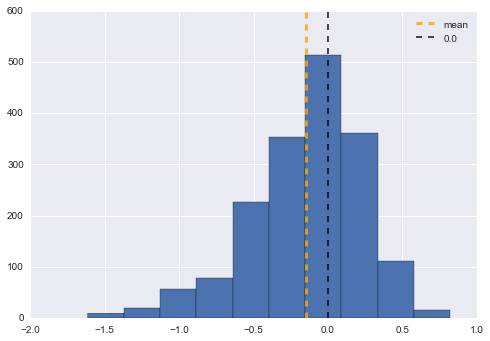

In [46]:
grid_df.value.hist()
plt.axvline(np.mean(grid_df.value), color="orange", alpha=0.8, ls='--', lw=3, label='mean')
plt.axvline(0.0, color="black", alpha=0.8, ls='--', label='0.0')
plt.legend()

## Look at the distribution of each of the parameters' values tested.

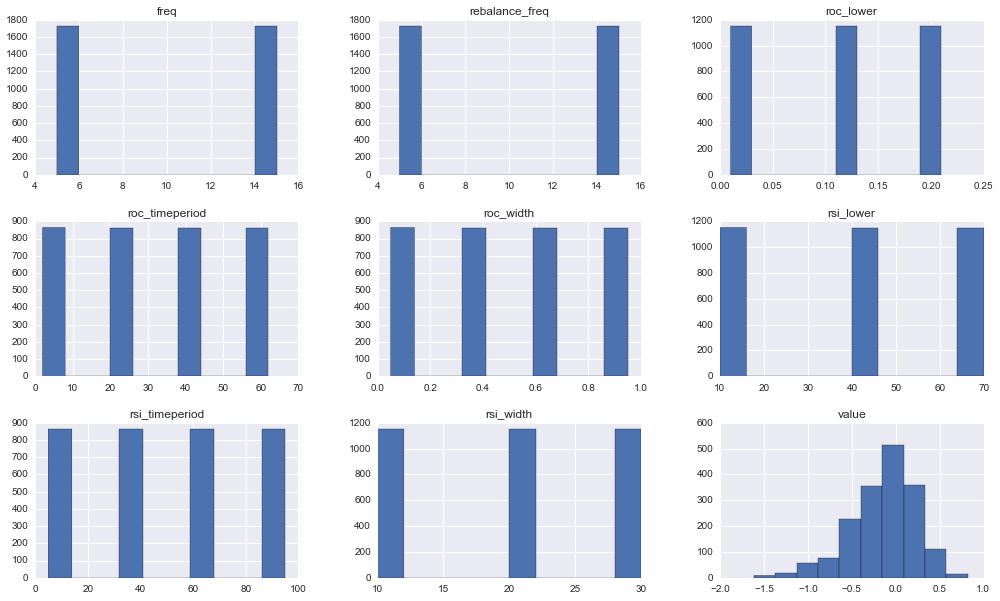

In [47]:
_=grid_df.hist(figsize=(17,10))

## Grid-Search: Run the best parameter combo from through the algorithm and plot the performance

In [14]:
# Specify the values of the best parameter combo in the signals dict, and rebalance frequency

input_params = {}

input_params['rebalance_freq'] = 5

signals = OrderedDict([
    ( 'rsi', {'func': talib.RSI, 'func_kwargs': {'timeperiod': 5}, 
                   'lower': 40,  'width': 10} ),
    ( 'roc', {'func': talib.ROCP, 'func_kwargs': {'timeperiod': 42 }, 
                   'lower': 0.01, 'width': 0.05} )  
    ])

input_params['signals_input'] = signals

In [15]:
algo_obj = zipline.TradingAlgorithm(
    initialize=initialize_local_sigopt_rsi_roc,
    handle_data=handle_data_local_sigopt_rsi_roc,
    **input_params
)

# Run algorithm using the training data
perf_manual = algo_obj.run(data)

rebal freq: 5
OrderedDict([('rsi', {'width': 10, 'lower': 40, 'func': <built-in function RSI>, 'func_kwargs': {'timeperiod': 5}}), ('roc', {'width': 0.05, 'lower': 0.01, 'func': <built-in function ROCP>, 'func_kwargs': {'timeperiod': 42}})])


0.820374098135


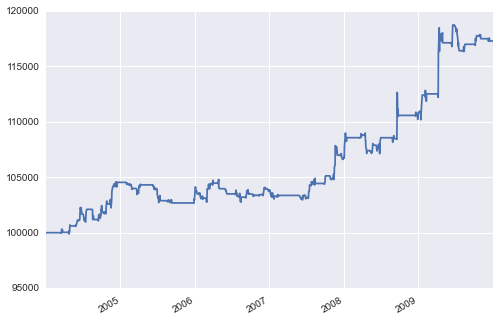

In [16]:
daily_rets = perf_manual.portfolio_value.pct_change().dropna()
sharpe_ratio_rets = daily_rets.mean() / daily_rets.std() * np.sqrt(252)
print sharpe_ratio_rets

perf_manual.portfolio_value.plot()

## Now see how well the strategy performs out-of-sample using the heldout data from 2010-2016

-0.857501142839


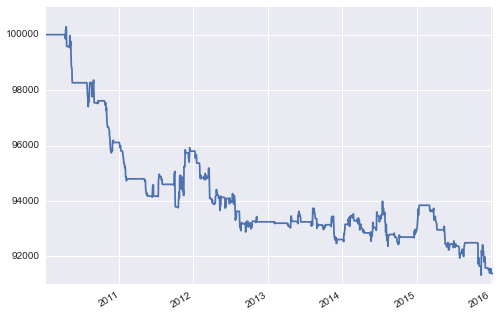

In [18]:
# Run algorithm using the training data
perf_manual = algo_obj.run(data_heldout)

daily_rets = perf_manual.portfolio_value.pct_change().dropna()
sharpe_ratio_rets = daily_rets.mean() / daily_rets.std() * np.sqrt(252)
print sharpe_ratio_rets

perf_manual.portfolio_value.plot()

# (Above) Seeing how poorly the strategy performs out-of-sample shows how important it is to perform additional analysis (cross-validation, out-of-sample testing, etc) after using parameter optimization to discover a global maximum

#Using SigOpt for Optimization

In [45]:
def run_sigopt_local_rsi_roc(samples=50, experiment_id=None,
                    client_token=None, **algo_descr):

    import sigopt.interface

    if client_token is None:
        raise ValueError('No sigopt credentials passed, find them at https://sigopt.com/user/profile')

    conn = sigopt.interface.Connection(client_token=client_token)

    if experiment_id != None:
        experiment = conn.experiments(experiment_id).fetch()
    else:
        experiment = conn.experiments().create(
            name='Quantopian_POC_talib_5_hedge_width',
            parameters=[
                {
                    'name': 'rsi_timeperiod',
                    'type': 'int',
                    'bounds': { 'min': 5, 'max': 126 }
                },
                {
                    'name': 'rsi_lower',
                    'type': 'int',
                    'bounds': { 'min': 0, 'max': 90 }
                },
                {
                    'name': 'rsi_width',
                    'type': 'int',
                    'bounds': { 'min': 10, 'max': 30 }
                },
                {
                    'name': 'roc_timeperiod',
                    'type': 'int',
                    'bounds': { 'min': 2, 'max': 63 }
                },
                {
                    'name': 'roc_lower',
                    'type': 'double',
                    'bounds': { 'min': 0.00, 'max': 0.30 }
                },
                {
                    'name': 'roc_width',
                    'type': 'double',
                    'bounds': { 'min': 0.05, 'max': 2.00 }
                },
                {
                    'name': 'rebalance_freq',
                    'type': 'int',
                    'bounds': { 'min': 3, 'max': 21 }
                },
            ],
        )

    for trial in range(samples):
        print("running trial: {0}".format(trial))
        suggestion = conn.experiments(experiment.id).suggestions().create()

        # Run the Zipline Algo with the SigOpt suggestion
        params_sugg = suggestion.assignments.to_json()
        print params_sugg
        
        signals = OrderedDict([
            ( 'rsi', {'func': talib.RSI, 'func_kwargs': {'timeperiod': params_sugg['rsi_timeperiod'] }, 
                           'lower': params_sugg['rsi_lower'],  'width': params_sugg['rsi_width']} ),
            ( 'roc', {'func': talib.ROCP, 'func_kwargs': {'timeperiod': params_sugg['roc_timeperiod'] }, 
                           'lower': params_sugg['roc_lower'], 'width': params_sugg['roc_width']} )  
            ])
        
        params_sugg['signals_input'] = signals
        algo_run = TradingAlgorithm(initialize=initialize_local_sigopt_rsi_roc, 
                                    handle_data=handle_data_local_sigopt_rsi_roc,
                                    **params_sugg
                                    )
        
        perf = algo_run.run(data)
        daily_rets = perf.portfolio_value.pct_change().dropna()
        
        if daily_rets.std() > 0:
            sharpe_ratio_calc = daily_rets.mean() / daily_rets.std() * np.sqrt(252)
        else:
            sharpe_ratio_calc = -999
        obj = sharpe_ratio_calc
        print obj      

        if obj < -900:
            print "*** Flagging as failed"
            conn.experiments(experiment.id).observations().create(
              assignments=suggestion.assignments,
              failed=True,
            )
        else:
            conn.experiments(experiment.id).observations().create(
              assignments=suggestion.assignments,
              value=obj,
            )

    exp_hist = conn.experiments(experiment.id).observations().fetch()
    exp_data = exp_hist.to_json()['data']
    exp_data.reverse() # start at the beginning

    # load up dataframe
    from collections import defaultdict
    sigopt_df_dict = defaultdict(list)
    for data_point in exp_data:
        for k, v in data_point['assignments'].iteritems():
            sigopt_df_dict[k].append(v)

        try:
            sigopt_df_dict['failed'].append(data_point['failed'])
        except:
            sigopt_df_dict['failed'].append(False)

        try:
            sigopt_df_dict['objective'].append(data_point['value'])
        except:
            sigopt_df_dict['objective'].append(-999)

    sigopt_df = pd.DataFrame(sigopt_df_dict)

    return sigopt_df

In [58]:
sigopt_df = run_sigopt_local_rsi_roc(samples=300,
                             experiment_id=None,
                             user_token=creds.user_token, 
                             client_token=creds.client_token, 
                             client_id=creds.client_id 
                            )

running trial: 0
{u'roc_timeperiod': 32, u'roc_lower': 0.1148092670590023, u'rsi_width': 29, u'rsi_timeperiod': 90, u'roc_width': 1.4373803958710658, u'rsi_lower': 16, u'rebalance_freq': 17}
rebal freq: 17
OrderedDict([('rsi', {'width': 29, 'lower': 16, 'func': <built-in function RSI>, 'func_kwargs': {'timeperiod': 90}}), ('roc', {'width': 1.4373803958710658, 'lower': 0.1148092670590023, 'func': <built-in function ROCP>, 'func_kwargs': {'timeperiod': 32}})])
-999
*** Flagging as failed
running trial: 1
{u'roc_timeperiod': 61, u'roc_lower': 0.0844961145944925, u'rsi_width': 18, u'rsi_timeperiod': 62, u'roc_width': 1.1383156724686605, u'rsi_lower': 36, u'rebalance_freq': 14}
rebal freq: 14
OrderedDict([('rsi', {'width': 18, 'lower': 36, 'func': <built-in function RSI>, 'func_kwargs': {'timeperiod': 62}}), ('roc', {'width': 1.1383156724686605, 'lower': 0.0844961145944925, 'func': <built-in function ROCP>, 'func_kwargs': {'timeperiod': 61}})])
0.296384194657
running trial: 2
{u'roc_timeper

In [22]:
sigopt_df.sort('objective', ascending=False).head()

,failed,objective,rebalance_freq,roc_lower,roc_timeperiod,roc_width,rsi_lower,rsi_timeperiod,rsi_width
4,False,-0.054690,3,0.168719,17,1.834614,33,75,28
3,False,-0.073903,17,0.205710,29,1.186417,64,8,18
1,False,-0.250872,20,0.014307,21,0.238028,35,95,23
0,True,-999.000000,8,0.109979,63,0.678920,82,44,11
2,True,-999.000000,10,0.236430,3,0.853963,70,107,26


In [41]:
# If you exported a CSV of your SigOpt results from your account page on the SigOpt website,
# you can read the results in like this. 
# To make it 'pandas friendly' you might want to replace 'None' with 'NA' prior to reading it in

sigopt_df = pd.read_csv('SigOpt_Experiment_good_2.csv')

In [42]:
sigopt_df.head()

,rsi_timeperiod,rsi_lower,rsi_width,roc_timeperiod,roc_lower,roc_width,rebalance_freq,value
0,27,55,17,16,0.132454,1.943223,7,0.337197
1,38,44,18,46,0.000729,0.812360,9,0.425559
2,66,89,13,4,0.168258,1.104381,16,NaN
3,119,76,21,35,0.057774,0.265620,3,NaN
4,86,21,12,51,0.250782,1.664795,11,NaN


In [43]:
sigopt_df.sort('value', ascending=False).head(10)

,rsi_timeperiod,rsi_lower,rsi_width,roc_timeperiod,roc_lower,roc_width,rebalance_freq,value
226,33,43,17,54,0,0.568999,12,1.009966
223,33,43,17,54,0,0.608607,12,1.009966
247,33,44,16,54,0,0.534478,12,1.009966
148,33,42,18,54,0,1.488573,12,1.009709
141,33,42,18,54,0,1.012120,12,1.009709
115,33,42,18,54,0,0.921427,12,1.009709
139,33,42,18,54,0,1.114055,12,1.009709
153,33,42,18,54,0,1.405196,12,1.009709
245,34,44,16,54,0,0.452321,12,1.009289
293,34,44,16,54,0,0.531977,12,0.990455


## View the distribution of all the values attempted by the SigOpt Bayesian Optimizer for each parameter in the trading model 

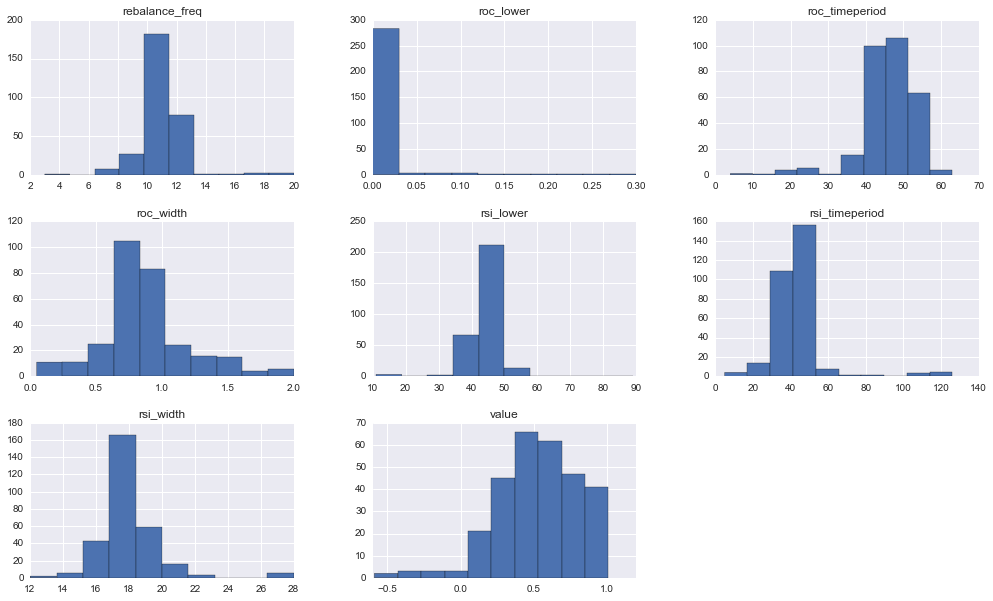

In [30]:
_=sigopt_df.hist(figsize=(17,10))

### Diagonal: Visualize the distribution of each parameter attempted by the SigOpt optimizer
### Scatterplots: Each individual parameter attempted vs. each of the others

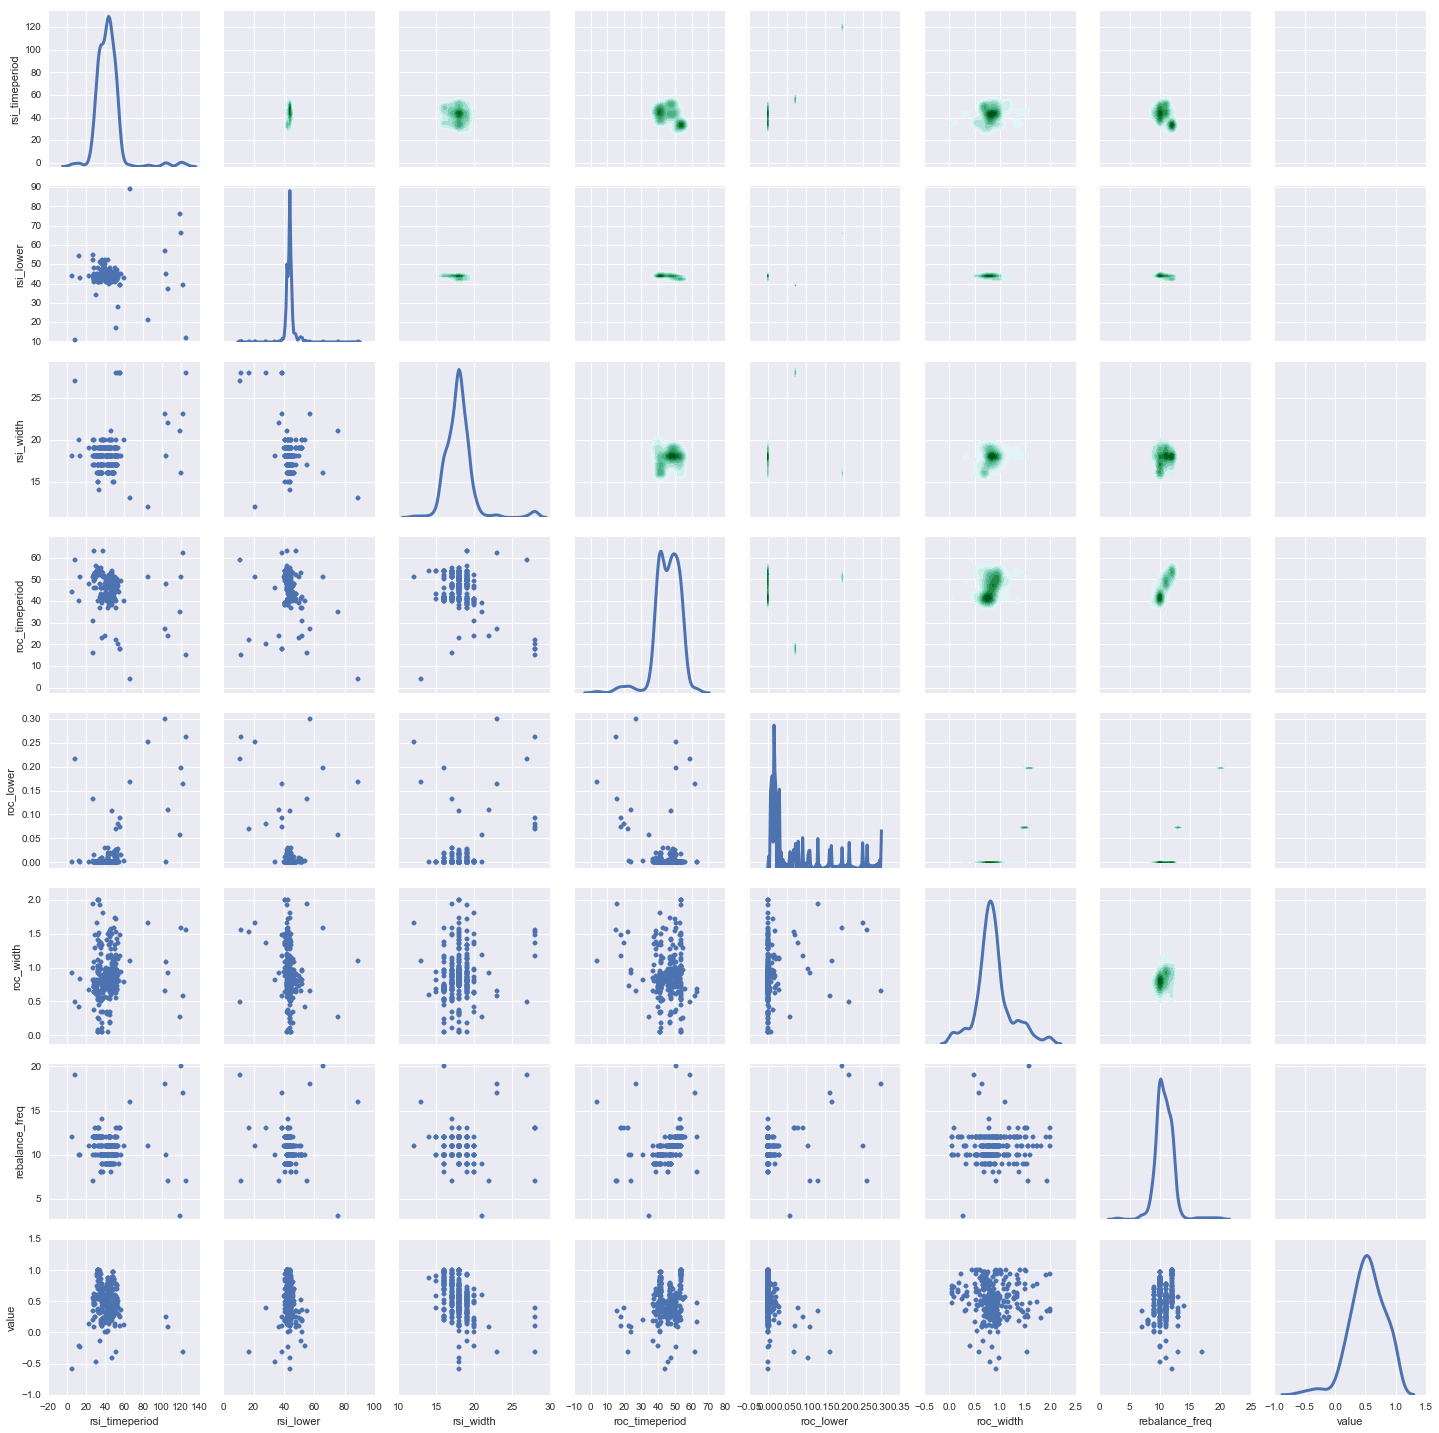

In [31]:
g = sns.PairGrid(sigopt_df, diag_sharey=False)
g.map_lower(plt.scatter, cmap="Blues_d")
g.map_upper(sns.kdeplot, shade=True, bw='silverman', shade_lowest=False)
g.map_diag(sns.kdeplot, lw=3)

In [65]:
# Specify the values of the best parameter combo in the signals dict, and rebalance frequency
# These values were pulled from the SigOpt export CSV
# filename: SigOpt_Experiment_good_2.csv 

input_params = {}

input_params['rebalance_freq'] = 12

signals = OrderedDict([
    ( 'rsi', {'func': talib.RSI, 'func_kwargs': {'timeperiod': 33 }, 
                   'lower': 44,  'width': 16} ),
    ( 'roc', {'func': talib.ROCP, 'func_kwargs': {'timeperiod': 54 }, 
                   'lower': 0.0, 'width': 0.534} )  
    ])

input_params['signals_input'] = signals

In [66]:
algo_obj = zipline.TradingAlgorithm(
    initialize=initialize_local_sigopt_rsi_roc,
    handle_data=handle_data_local_sigopt_rsi_roc,
    **input_params
)

# Run algorithm using the training data
perf_manual = algo_obj.run(data)

rebal freq: 12
OrderedDict([('rsi', {'width': 16, 'lower': 44, 'func': <built-in function RSI>, 'func_kwargs': {'timeperiod': 33}}), ('roc', {'width': 0.534, 'lower': 0.0, 'func': <built-in function ROCP>, 'func_kwargs': {'timeperiod': 54}})])


1.00996603411


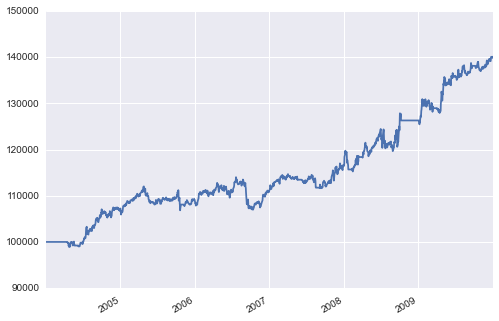

In [67]:
daily_rets = perf_manual.portfolio_value.pct_change().dropna()
sharpe_ratio_rets = daily_rets.mean() / daily_rets.std() * np.sqrt(252)
print sharpe_ratio_rets

perf_manual.portfolio_value.plot()

-1.10345060794


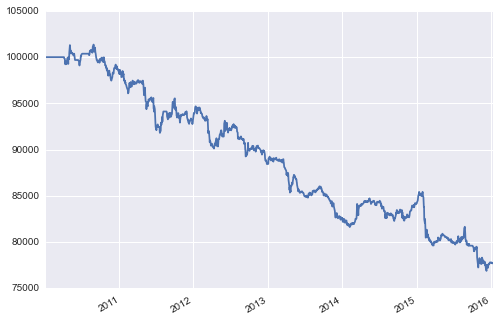

In [68]:
# Run algorithm using the heldout, out-of-sample data
perf_manual = algo_obj.run(data_heldout)

daily_rets = perf_manual.portfolio_value.pct_change().dropna()
sharpe_ratio_rets = daily_rets.mean() / daily_rets.std() * np.sqrt(252)
print sharpe_ratio_rets

perf_manual.portfolio_value.plot()

# (Above) Again, as before, seeing how poorly the strategy performs out-of-sample illustrates how important it is to perform additional analysis after using parameter optimization to discover a global maximum

One way to combat this overfitting is to use performance on a cross-validated or holdout dataset as the metric being optimized. This forces the algorithm to be robust to never-before-seen data and allows the optimizer to find potentially better overall results. For an example of using SigOpt to tune on a cross-validated dataset, with results on a holdout dataset check out [this blog post](http://blog.sigopt.com/post/136340340198/sigopt-for-ml-using-model-tuning-to-beat-vegas) (with code).

# Let's take a deep dive into what we found

### How fast did we find our best result?
#### SigOpt typically discovers a higher global maximum nearly 10x faster than a tuned grid-search

In practice SigOpt is able to find a good optima in a linear number of evaluations with respect to the number of parameters being tuned (usually between 10 and 20 times the dimensionality of the parameter space). Grid search, even an expertly tuned grid search, grows exponentially with the number of parameters. As the model being tuned becomes more complex it can quickly become completely intractable to tune a model using these traditional methods.

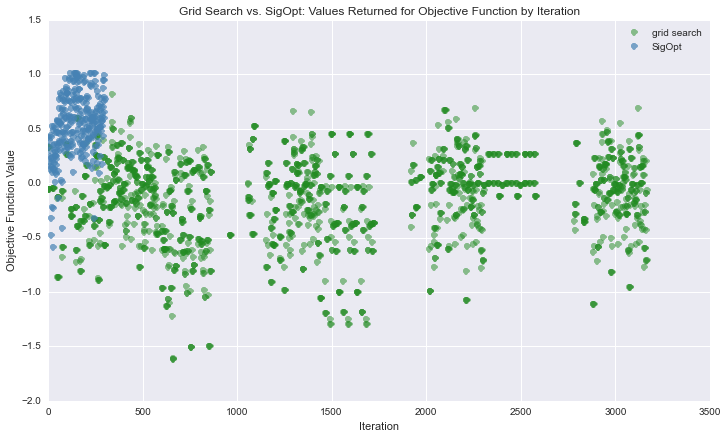

In [105]:
plt.figure(figsize=(10,6));
plt.title("Grid Search vs. SigOpt: Values Returned for Objective Function by Iteration");
plt.plot(grid_df.value.values, alpha=0.5, color='forestgreen', label='grid search', marker='o', linestyle='')
plt.plot(sigopt_df.value.values, alpha=0.7, color='steelblue', label='SigOpt', marker='o', linestyle='')
plt.tight_layout()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.savefig('SigOpt_vs_GridSearch_time_comparison.png', dpi=300)

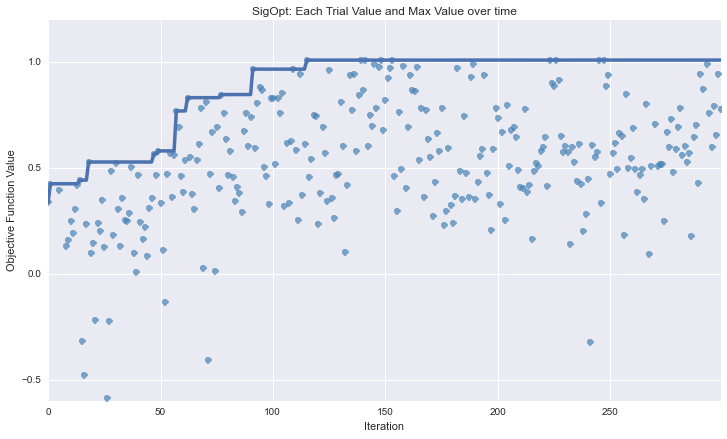

In [106]:
plt.figure(figsize=(10,6));
plt.title("SigOpt: Each Trial Value and Max Value over time");
plt.plot(sigopt_df.value, alpha=0.7, color='steelblue', label='SigOpt', marker='o', linestyle='')
np.maximum.accumulate(sigopt_df.value.fillna(0)).plot(lw=3.5)
plt.tight_layout()
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.savefig('SigOpt_max_over_time.png', dpi=300)

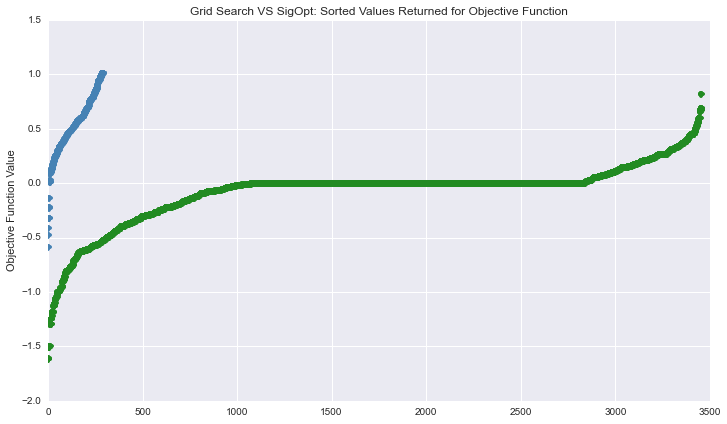

In [103]:
plt.figure(figsize=(10,6));
plt.title("Grid Search VS SigOpt: Sorted Values Returned for Objective Function");
plt.plot(np.sort(grid_df.fillna(0.0).value), color='forestgreen', lw=3, marker='o', ls='')
plt.plot(np.sort(sigopt_df.value), color='steelblue', lw=3, marker='o', ls='')
plt.tight_layout()
plt.legend()
plt.ylabel("Objective Function Value")
plt.savefig('SigOpt_vs_GridSearch_sorted_value_comparison.png', dpi=300)

## What does the distribution of objective function values found look like?  
##SigOpt vs. grid search

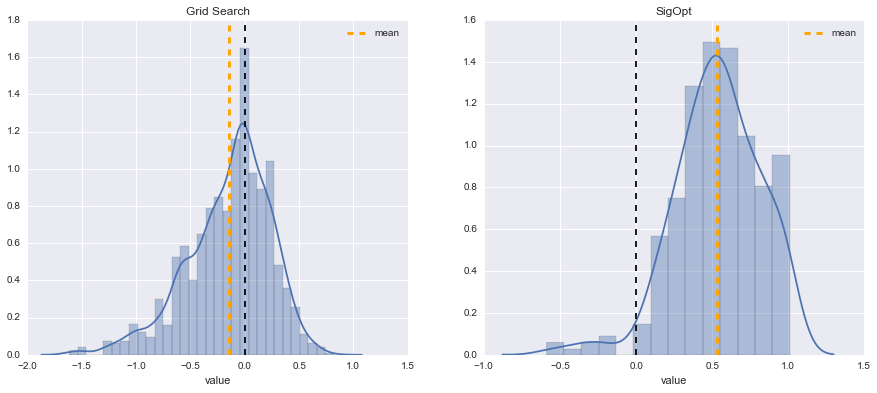

In [75]:
plt.figure(figsize=(15,6));
gs = plt.GridSpec(1,2);
plt.subplot(gs[0]);
sns.distplot(grid_df.value.dropna())
plt.axvline(0.0,c='k',ls='--')
plt.axvline(np.mean(grid_df.value),c='orange',ls='--', lw=3, label='mean')
plt.legend()
plt.title("Grid Search");

plt.subplot(gs[1]);
sns.distplot(sigopt_df.value.dropna())
plt.axvline(0.0,c='k',ls='--')
plt.axvline(np.mean(sigopt_df.value),c='orange',ls='--', lw=3, label='mean')
plt.legend()
plt.title("SigOpt");

## Make a Pyfolio Tearsheet if you have it installed

### Run the Zipline algo over the entire date range, then we'll highlight the Out-of-sample period within Pyfolio

In [76]:
# Specify the values of the best parameter combo in the signals dict, and rebalance frequency
# These values were pulled from the SigOpt export CSV
# filename: SigOpt_Experiment_good_2.csv 

input_params = {}

input_params['rebalance_freq'] = 12

signals = OrderedDict([
    ( 'rsi', {'func': talib.RSI, 'func_kwargs': {'timeperiod': 33 }, 
                   'lower': 44,  'width': 16} ),
    ( 'roc', {'func': talib.ROCP, 'func_kwargs': {'timeperiod': 54 }, 
                   'lower': 0.0, 'width': 0.534} )  
    ])

input_params['signals_input'] = signals

algo_obj = zipline.TradingAlgorithm(
    initialize=initialize_local_sigopt_rsi_roc,
    handle_data=handle_data_local_sigopt_rsi_roc,
    **input_params
)

perf_manual = algo_obj.run(data_all)

# First need to normalize, and localize all the timestamps
perf_manual.index = perf_manual.index.normalize()
if perf_manual.index.tzinfo is None:
    perf_manual.index = perf_manual.index.tz_localize('UTC')
returns = perf_manual.returns


rebal freq: 12
OrderedDict([('rsi', {'width': 16, 'lower': 44, 'func': <built-in function RSI>, 'func_kwargs': {'timeperiod': 33}}), ('roc', {'width': 0.534, 'lower': 0.0, 'func': <built-in function ROCP>, 'func_kwargs': {'timeperiod': 54}})])


Entire data start date: 2004-01-02
Entire data end date: 2016-01-07


Out-of-Sample Months: 71
Backtest Months: 72
                         Backtest  Out of sample  All history
annual_return                0.06          -0.03         0.01
annual_volatility            0.06           0.04         0.05
sharpe_ratio                 1.03          -0.89         0.25
calmar_ratio                 0.94          -0.17         0.05
stability_of_timeseries      0.94          -0.92         0.57
max_drawdown                -0.06          -0.20        -0.20
omega_ratio                  1.22           0.85         1.05
sortino_ratio                1.49          -1.18         0.36
skew                        -0.19          -0.33        -0.17
kurtosis                     4.32           4.23         5.30
information_ratio            0.00          -0.06        -0.02
alpha                        0.06          -0.03         0.02
beta                        -0.03          -0.05        -0.04

Worst Drawdown P

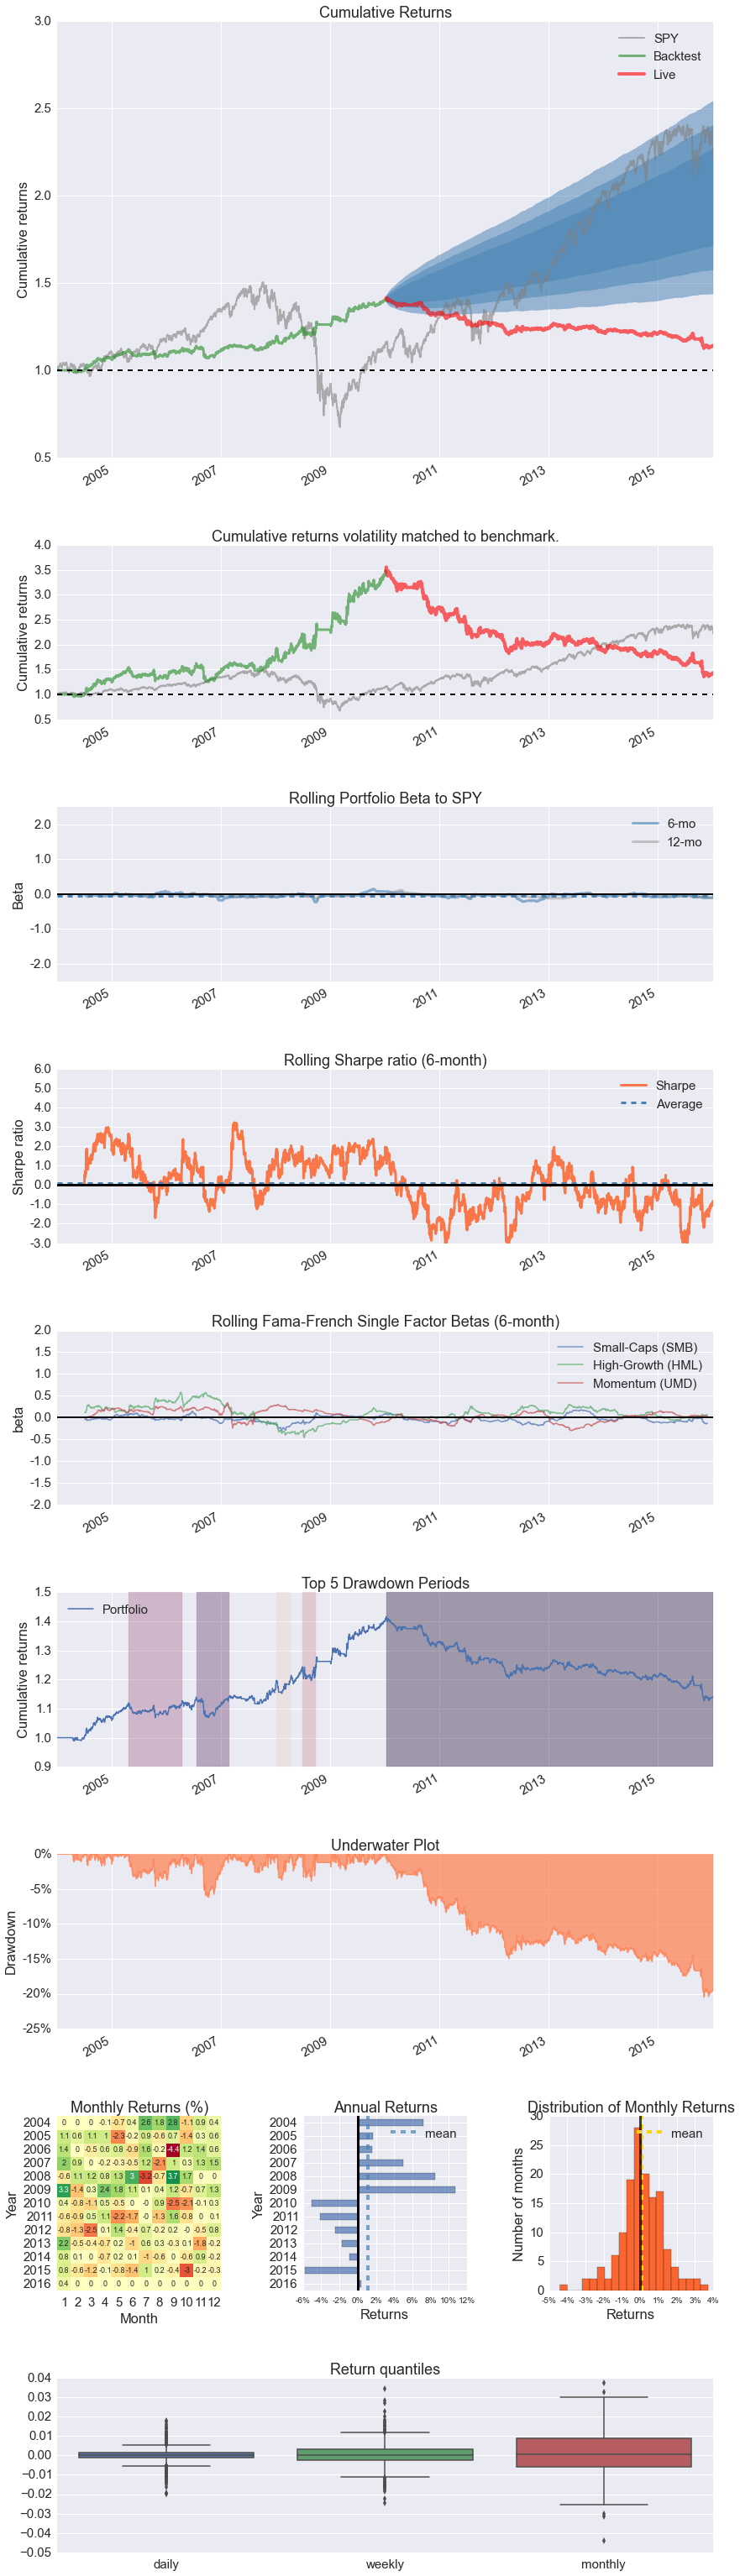

In [77]:
# Render the tearsheet
pf.create_returns_tear_sheet(returns, live_start_date='01-10-2010')